### <font color="red">NOTE</font>

When you run this notebook, execution will fail at some point.  This is expected, done like that by design.

The cell notes will instruct you to skip that cell and continue execution below it.

This was developed/tested in Google Colab, Python 3.10.12.

Also tested locally in VS Code, Python 3.9.16

# Project:  BCCR CRC/USD exchange rate extraction using webscraping

## Objective

The Central Bank of Costa Rica website where the latest information is provided is found at:

https://gee.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?idioma=1&CodCuadro=%20400


The page also offers the option of exporting a file of the daily exchange history since 1983-01-01.

The objective of this project is to produce a file that contains the most up to date CRC/USD exchange rate, that can later be used in other data science projects, as input data, for example as a new column, merging it to other tables/dataframes using the date index.



## Methodology

The steps that the code follows to fulfill the objective, are:


1. Download the exchange rate historical file. Using Selenium is needed as a click on an image is required
2. Extract the table using Pandas pd.extract_html
3. Get the headers and data from the table
4. Store the previos step items into a Pandas dataframe
5. Backup the dataframe into a file.  In a real scenario, that file should only be produced perhaps only once a month
6. Using BeautifulSoup, scrape the latest exchange rate data from the page.  It is updated daily by the bank (BCCR), and it contains the last 30 days
7. Load the scraped data into a dataframe
8. Repeat steps 3-4 to the scraped data dataframe
9. Load exchange rate file that was produced at step 5 into another dataframe
10. Add the newest records found at df from step 7, to the dataframe from step 9
11. Overwrite file from step 5 with the dataframe from previous step


---
## Description of used Packages and libraries

selenium - to be able to simulate the click of a button\
os - file operations such as renaming or getting the creation file\
requests - webscrapping of newer results\
shutil - High-level file operations, used to easily\ copy a file as a backup\
fastparquet - needed to produce a parquet file
matplotlib - basic plotting
pandas - dataframe operations \
numpy - required by Pandas\
datetime - timestamp operations\
bf4 - beautifulsoup for webscrapping
\
lxml - may process soups better than html   \
html5lib - may process soups better than html   \
python-magic / magic - needed to check/confirm file format
apt install -qq chromium-chromedriver  ----  installed at OS level as this is required by Selenium

---
## Findings/Lessons learned






###Usage of Selenium package/library

https://selenium-python.readthedocs.io/getting-started.html

The file is generated by clicking on a button defined by an image.  Requests nor BeautifulSoup can be used to click on button.

It is then found online that the Selenium library is used to perform browser interaction tasks such as the click of a button, so I used it to perform the file generation

The tag line of the image button is the following:

\<img onmouseover="this.src = '/indicadoreseconomicos\Imagenes\bexport_on.gif'; this.style.cursor = 'pointer';" onclick="js_doExport();" onmouseout="this.src = '/indicadoreseconomicos\Imagenes\bexport_off.gif'; this.style.cursor = 'default';" height="27" alt="Exportar datos a Excel" src="/indicadoreseconomicos\Imagenes\bexport_off.gif" width="38" border="0" style="cursor: default;">

### Data Wrangling

The BCCR (Central Bank of Costa Rica) seems not to follow a clean way to built html tables that are present at the website that hold the dollar exchange rate.   The html table structure is disorganized, for example the main table has nested tables inside of it, sometimes even just empty tables.

The original data needed the following cleaning:


1.   Original file extension was XLS, but in reality it was an html file.  So pd.read_excel had to be replaced by pd.read_html

2.   First 3 rows of the data were really descriptors of the table, that were using 10 colums instead of the 3 that the real data is using.  This caused problems with the load woth pd.read_html.   So, wrote code to modify the html parameter of those column spans from 10 to 1.  Then dataframe was loaded skipping those first 3 lines.

3.   When trying to convert the index to date format, there was a failure because the dataframe contains
Feb 29th entries for years that were not a leap year.  Those lines were simply dropped, as the data on them was null anyway

4. The following treatment needs to be done to the dataframe, in order for it to be properly formatted:

-setting the header as the resulting line with index 0\
-setting the index as the first column\
-recognizing the original decimal char as the comma, so dataframe is shown as usual with it as a dot (thousands must also be declared as dot for this to work properly)\
-set floating numbers with 2 decimals\
-name the columns properly \


###Data backup storage saving

Code was written to generate a backup of the generated file, as soon as it is downloaded.

By testing backups on different format files, in terms of storage space it was found that html file is the worst choice.   Parquet file is the one we can choose to make backups for the least amount of space.



---


## Enhancement opportunities


1.   File generation and download

By inspecting the extracted html, it was found that the file can actually be generated directly by modifying the query string values of the following URL

https://gee.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?CodCuadro=400&Idioma=1&FecInicial=2023/01/01&FecFinal=2024/07/19&Filtro=0&Exportar=True&Excel=True

Basically the initial and end dates can be modified at will to get the necessary file.

This can be done to avoid having to use logic (with Selenium) to simulate the clicking of the button to generate the file, so the code is smaller and quicker.
\
2.   Add code to download the full historical file, once a month.
\
3.   Add code to check if the updated exchange file is missing more than just one record (today), if it is, then complete the missing records from the fresh scraped data that should be done every day
\
4.   Clean the backup logic, the files at the end look a bit disorganized.  Some need timestamp at the filename






---

#Project Code





##Packages,Libraries,Constants

Packages installation takes about 2 minutes

In [1]:
!pip -V

pip 24.1.2 from /home/milos/Documents/Proyectos/CienciaDeDatos/CRC-tipo-de-cambio/venv/lib/python3.9/site-packages/pip (python 3.9)


In [2]:
!pip install --upgrade pip

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:
!pip -V

pip 24.2 from /home/milos/Documents/Proyectos/CienciaDeDatos/CRC-tipo-de-cambio/venv/lib/python3.9/site-packages/pip (python 3.9)


In [4]:
!pip install --quiet matplotlib selenium html5lib python-magic fastparquet
# !apt-get update
# !apt install chromium-chromedriver
import os ,requests, shutil, time, bs4, lxml, magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime


In [5]:
!pip freeze | grep selenium

selenium==4.23.0


In [6]:
# Constants
DATASETS_PATH = './datasets'
DATASETS_TEMP_PATH = f'{DATASETS_PATH}/temp'
DATASETS_BACKUP_PATH = f'{DATASETS_PATH}/backups'
CURRENT_DATASET_BASEFILENAME = 'bccr_historial_cambio_dolar'

## Downloading the dollar exchange historical data from the bank webpage, with Selenium

To then load it into a Pandas dataframe, and back it up in a file

In [7]:
# This is just to be able to use locate linux command to check a bit for chromedriver installation
!apt-get -qq install mlocate > /dev/null

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [8]:
# Initially chromedriver is missing
!updatedb
!locate chromedriver

updatedb: can not open a temporary file for `/var/lib/mlocate/mlocate.db'
/home/milos/.cache/selenium/chromedriver
/home/milos/.cache/selenium/chromedriver/linux64
/home/milos/.cache/selenium/chromedriver/linux64/125.0.6422.141
/home/milos/.cache/selenium/chromedriver/linux64/125.0.6422.141/chromedriver


In [9]:
!which chromedriver

In [10]:
# Chromedriver instalation.  Required by Selenium
!apt install -qq chromium-chromedriver > /dev/null



E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [11]:
# Confirming it is installed now
!updatedb
!locate chromedriver

updatedb: can not open a temporary file for `/var/lib/mlocate/mlocate.db'


/home/milos/.cache/selenium/chromedriver
/home/milos/.cache/selenium/chromedriver/linux64
/home/milos/.cache/selenium/chromedriver/linux64/125.0.6422.141
/home/milos/.cache/selenium/chromedriver/linux64/125.0.6422.141/chromedriver


In [12]:
!which chromedriver

### Selenium config and parameters

In [13]:
# Set up Chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')  # Run Chrome in headless mode (so it does not attempt to open the browser onscreen. In google colab of ccurse there is no screen as it uses a virtual machine)
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
# Adding a UA to try minimize the probability of bank blocking request because the default python UA
chrome_options.add_argument("user-agent = Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36")
# Initialize Chrome WebDriver
driver = webdriver.Chrome(options=chrome_options)
driver.implicitly_wait(10) # seconds, this is used to ensure all objects
#have been downloaded before taking actions

# Set up Chrome download options (dont ask file name/saving dir)
# dnld_params = { 'behavior': 'allow', 'downloadPath': os.getcwd() } #download to current dir
dnld_params = { 'behavior': 'allow', 'downloadPath': DATASETS_TEMP_PATH } #download to specified temp dir
driver.execute_cdp_cmd ('Page.setDownloadBehavior', dnld_params)

{}

### Selenium run

In [14]:
# Navigate to the page. Unlike Requests, Selenium needs the query strings directly at the URL
driver.get('https://gee.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?idioma=1&CodCuadro=%20400')


In [15]:
driver.current_url

'https://gee.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?idioma=1&CodCuadro=%20400'

The tag line of the image button is the following:

\<img onmouseover="this.src = '/indicadoreseconomicos\\Imagenes\\bexport_on.gif'; this.style.cursor = 'pointer';" onclick="js_doExport();" onmouseout="this.src = '/indicadoreseconomicos\\Imagenes\\bexport_off.gif'; this.style.cursor = 'default';" height="27" alt="Exportar datos a Excel" src="/indicadoreseconomicos\Imagenes\bexport_off.gif" width="38" border="0" style="cursor: default;">

The **alt** tag is the one that can be used as a selector in selenium

In [16]:
!date
!ps -ef | grep chromedriver | grep -v grep

jue  1 ago 01:48:31 CST 2024
milos    20662 20379  4 01:48 ?        00:00:00 /home/milos/.cache/selenium/chromedriver/linux64/125.0.6422.141/chromedriver --port=55729


### Finding the image that needs to be clicked to generate the file

In [17]:
# Find the image element (adjust the locator as needed)

# this one uses explicit delay (10 secs) to ensure objects have loaded
# help>   https://selenium-python.readthedocs.io/waits.html
image_button = WebDriverWait(driver, 15).until(
    EC.presence_of_element_located((By.XPATH, '//img[@alt="Exportar datos a Excel" ]')) ) # Replace with the actual XPath

# another way is
#help>  https://selenium-python.readthedocs.io/locating-elements.html
# driver.implicitly_wait(10) # seconds
# image_button = driver.find_element(By.XPATH, '//img[@alt="Exportar datos a Excel"]')

### Click the image (to trigger the download)

*   List item
*   List item



In [18]:
# Click the image (to trigger the download)
image_button.click()

# Get the image source URL in case we want to download that image
# This line is not needed to click on the image
image_url = image_button.get_attribute('src')

In [19]:
!date
!ps -ef | grep chromedriver | grep -v grep

jue  1 ago 01:48:31 CST 2024
milos    20662 20379  4 01:48 ?        00:00:00 /home/milos/.cache/selenium/chromedriver/linux64/125.0.6422.141/chromedriver --port=55729


In [20]:
# This cell is not really necessary, it just a test made here
# Send a request to download the image file, # Save the downloaded file locally if needed
response = requests.get(image_url)
local_filename = 'downloaded_image.jpg'  #
with open(local_filename, 'wb') as f:
    f.write(response.content)

In [21]:
# Sometimes the download does not finish and it is stuck at the .crdownload temporary file
# This piece of code makes sure the download to {DATASETS_PATH}/temp actually happened
# Setting a timeout to check that file has finished downloading

timeout = time.time() + 45  # 45 seconds from now
count = 1
while True:
          #  check if dir is there  and check if download already started with a temp crdownload file
  if (os.path.exists(f'{DATASETS_PATH}/temp')):
    # check if there is any file at the temp dir
      if len(os.listdir(f'{DATASETS_PATH}/temp')) !=0:
       #check if download already started with a temp crdownload file
        if (os.listdir(f'{DATASETS_PATH}/temp')[0].find('crdownload') != -1) and (count>0):
          print(datetime.today().strftime('%Y%m%d %H:%M:%S') + ' --- ' + f'Download dir {DATASETS_PATH}/temp created, download started')
          print(os.listdir(f'{DATASETS_PATH}/temp'))
          print('Wait for download completion....')
          count-=1  #so message is printed only once
        #  check if download completed when crdownload extension is removed
        if (os.listdir(f'{DATASETS_PATH}/temp')[0].find('crdownload') == -1):
          print(datetime.today().strftime('%Y%m%d %H:%M:%S') + ' --- ' + f'Download completed')
          print(os.listdir(f'{DATASETS_PATH}/temp'))
          downloaded_filename = os.listdir(f'{DATASETS_PATH}/temp')[0]
          shutil.move(  f'{DATASETS_PATH}/temp/{downloaded_filename}' , f'{DATASETS_PATH}/{downloaded_filename}' )
          print(datetime.today().strftime('%Y%m%d %H:%M:%S') + ' --- ' + f'File moved to {DATASETS_PATH} directory')
          break
  if time.time() > timeout:
    print(datetime.today().strftime('%Y%m%d %H:%M:%S') + ' --- ' + "Timed out waiting for datasets directory to be created, or file was not downloaded completely/at all")
    break
  time.sleep(3)

# If there are errors downloading file, you may need to disconnect the runtime and start over
# Possibly the website is blocking scraping, and code needs to be enhanced to try avoid the block
# Or maybe there was just a temporary network issue...

20240801 01:48:35 --- Download completed
['frmVerCatCuadro.xls']
20240801 01:48:35 --- File moved to ./datasets directory


In [22]:
os.listdir(DATASETS_PATH)

['bccr_historial_cambio_dolar.parquet',
 'frmVerCatCuadro.xls',
 'backups',
 'bccr_historial_cambio_dolar.html',
 'temp']

In [23]:
list(os.walk(DATASETS_PATH))

[('./datasets',
  ['backups', 'temp'],
  ['bccr_historial_cambio_dolar.parquet',
   'frmVerCatCuadro.xls',
   'bccr_historial_cambio_dolar.html']),
 ('./datasets/backups',
  [],
  ['bccr_historial_cambio_dolar.parquet',
   'bccr_historial_cambio_dolar.csv',
   'bccr_historial_cambio_dolar.html.20240722',
   'bccr_historial_cambio_dolar.pkl',
   'bccr_historial_cambio_dolar.xlsx']),
 ('./datasets/temp', [], [])]

In [24]:
!date ; ls -lh datasets/*

jue  1 ago 01:48:35 CST 2024
-rw-r--r-- 1 milos milos 2,8M jul 22 17:54 datasets/bccr_historial_cambio_dolar.html
-rw-r--r-- 1 milos milos 189K jul 22 17:55 datasets/bccr_historial_cambio_dolar.parquet
-rw-rw-r-- 1 milos milos 2,9M ago  1 01:48 datasets/frmVerCatCuadro.xls

datasets/backups:
total 4,0M
-rw-r--r-- 1 milos milos 360K jul 22 17:55 bccr_historial_cambio_dolar.csv
-rw-r--r-- 1 milos milos 2,9M jul 22 17:54 bccr_historial_cambio_dolar.html.20240722
-rw-r--r-- 1 milos milos 189K jul 22 17:55 bccr_historial_cambio_dolar.parquet
-rw-r--r-- 1 milos milos 357K jul 22 17:55 bccr_historial_cambio_dolar.pkl
-rw-r--r-- 1 milos milos 267K jul 22 17:55 bccr_historial_cambio_dolar.xlsx

datasets/temp:
total 0


In [25]:
downloaded_filename

'frmVerCatCuadro.xls'

In [26]:
# Close the chromedriver to free up memory
driver.quit()

### Discovering that the downloaded .xls file is actually NOT and Excel file

In [27]:
# the supposed xls file is actually an html document, not excel  -- checked in linux
!file datasets/*

datasets/backups:                             directory
datasets/bccr_historial_cambio_dolar.html:    HTML document, ASCII text
datasets/bccr_historial_cambio_dolar.parquet: Apache Parquet
datasets/frmVerCatCuadro.xls:                 HTML document, ASCII text, with CRLF line terminators
datasets/temp:                                directory


In [28]:
# The same as above but done in python code
# requires to pip install python-magic and import magic

magic.from_file(f'{DATASETS_PATH}/{downloaded_filename}')

'HTML document, ASCII text, with CRLF line terminators'

In [29]:
# os.path.getctime('./datasets/frmVerCatCuadro.xls')
os.path.getctime(f'{DATASETS_PATH}/{downloaded_filename}')

1722498515.3165169

In [30]:
### NOTE: this code was initially used, but later not used because
#the variable downloaded_filename was created.  I left it here as it may be useable on some other project

# Generate the name of the most recent file by creation time, found at ./datasets directory
def find_most_recent_ds_file(directory):
#Finds the most recently modified file in a directory.
  files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
  if not files:
    return None

  most_recent_file = max(files, key=lambda f: os.path.getctime(os.path.join(directory, f)))
  return most_recent_file

most_recent_ds_file = find_most_recent_ds_file(DATASETS_PATH)
most_recent_ds_file


'frmVerCatCuadro.xls'

In [31]:
CURRENT_DATASET_BASEFILENAME

'bccr_historial_cambio_dolar'

In [32]:
# rename file to a more distiguishable name and also back it up just in case
os.rename( f'{DATASETS_PATH}/{downloaded_filename}' ,
          f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html')

In [33]:
# Creating a backup file

current_timestamp = datetime.today().strftime('%Y%m%d')
os.makedirs(f'{DATASETS_BACKUP_PATH}', exist_ok=True)
shutil.copyfile(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html',
                f'{DATASETS_BACKUP_PATH}/{CURRENT_DATASET_BASEFILENAME}.html.{current_timestamp}')

'./datasets/backups/bccr_historial_cambio_dolar.html.20240801'

In [34]:
ls -lh datasets/*

-rw-rw-r-- 1 milos milos 2,9M ago  1 01:48 datasets/bccr_historial_cambio_dolar.html
-rw-r--r-- 1 milos milos 189K jul 22 17:55 datasets/bccr_historial_cambio_dolar.parquet

datasets/backups:
total 6,9M
-rw-r--r-- 1 milos milos 360K jul 22 17:55 bccr_historial_cambio_dolar.csv
-rw-r--r-- 1 milos milos 2,9M jul 22 17:54 bccr_historial_cambio_dolar.html.20240722
-rw-rw-r-- 1 milos milos 2,9M ago  1 01:48 bccr_historial_cambio_dolar.html.20240801
-rw-r--r-- 1 milos milos 189K jul 22 17:55 bccr_historial_cambio_dolar.parquet
-rw-r--r-- 1 milos milos 357K jul 22 17:55 bccr_historial_cambio_dolar.pkl
-rw-r--r-- 1 milos milos 267K jul 22 17:55 bccr_historial_cambio_dolar.xlsx

datasets/temp:
total 0


In [35]:
print(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html')

./datasets/bccr_historial_cambio_dolar.html


### Import test of dataframe from the downloaded file




In [36]:
# Converting html to dataframe

pd.read_html(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html')[0].shape


(15225, 10)

In [37]:
# The resulting dataframe is shown with
pd.read_html(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html')[0].iloc[: , :] .head(7)

,0,1,2,3,4,5,6,7,8,9
0,Tipo cambio de compra y de venta del dólar de ...,Tipo cambio de compra y de venta del dólar de ...,Tipo cambio de compra y de venta del dólar de ...,Tipo cambio de compra y de venta del dólar de ...,Tipo cambio de compra y de venta del dólar de ...,Tipo cambio de compra y de venta del dólar de ...,Tipo cambio de compra y de venta del dólar de ...,Tipo cambio de compra y de venta del dólar de ...,Tipo cambio de compra y de venta del dólar de ...,Tipo cambio de compra y de venta del dólar de ...
1,Referencia del Banco Central de Costa Rica,Referencia del Banco Central de Costa Rica,Referencia del Banco Central de Costa Rica,Referencia del Banco Central de Costa Rica,Referencia del Banco Central de Costa Rica,Referencia del Banco Central de Costa Rica,Referencia del Banco Central de Costa Rica,Referencia del Banco Central de Costa Rica,Referencia del Banco Central de Costa Rica,Referencia del Banco Central de Costa Rica
2,En colones costarricenses,En colones costarricenses,En colones costarricenses,En colones costarricenses,En colones costarricenses,En colones costarricenses,En colones costarricenses,En colones costarricenses,En colones costarricenses,En colones costarricenses
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,TIPO CAMBIO COMPRA,TIPO DE CAMBIO VENTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1 Ene 1983,4495000000,4545000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2 Ene 1983,4495000000,4545000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Looks like read_html gets confused due to the table descriptors being spanned to 10 columns
_# so it then forces the whole table to be 10 columns wide, with lots of nulls at the added columns 3 to 9
!grep 'TD colSpan' datasets/bccr_historial_cambio_dolar.html

        <TR><TD colSpan="10" class=texto><a name="DataExported">Tipo cambio de compra y de venta del d&oacute;lar de los Estados Unidos de Am&eacute;rica</a></TD></TR>
        <TR><TD colSpan="10" class=texto>Referencia del Banco Central de Costa Rica</TD></TR>
        <TR><TD colSpan="10" class=texto>En colones costarricenses</TD></TR>


In [39]:
# One potential solution is to slice the DF
pd.read_html(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html')[0].iloc[4: , :3].head()

,0,1,2
4,NaN,TIPO CAMBIO COMPRA,TIPO DE CAMBIO VENTA
5,1 Ene 1983,4495000000,4545000000
6,2 Ene 1983,4495000000,4545000000
7,3 Ene 1983,4495000000,4545000000
8,4 Ene 1983,4495000000,4545000000


In [40]:
# But, I want to test the theorical error caused by colsSpan=10,
#so let's change its value to just 1 and see what happens

search_txt = 'TD colSpan="10"'
replace_txt = 'TD colSpan="1"'
with open(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html', 'r') as file:
    filedata = file.read()
    filedata = filedata.replace(search_txt, replace_txt)
with open(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html', 'w') as file:
    file.write(filedata)

In [41]:
!grep 'TD colSpan' datasets/bccr_historial_cambio_dolar.html

        <TR><TD colSpan="1" class=texto><a name="DataExported">Tipo cambio de compra y de venta del d&oacute;lar de los Estados Unidos de Am&eacute;rica</a></TD></TR>
        <TR><TD colSpan="1" class=texto>Referencia del Banco Central de Costa Rica</TD></TR>
        <TR><TD colSpan="1" class=texto>En colones costarricenses</TD></TR>


In [42]:
# And it does work
pd.read_html(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html')[0].iloc[:, :].head(7)

,0,1,2
0,Tipo cambio de compra y de venta del dólar de ...,NaN,NaN
1,Referencia del Banco Central de Costa Rica,NaN,NaN
2,En colones costarricenses,NaN,NaN
3,NaN,NaN,NaN
4,NaN,TIPO CAMBIO COMPRA,TIPO DE CAMBIO VENTA
5,1 Ene 1983,4495000000,4545000000
6,2 Ene 1983,4495000000,4545000000


### Definitive Importing/Cleaning of the dataset

In [43]:
# Now lets import the df properly, by:
# -skiping the first 4 lines
# -setting the header as the resulting line with index 0
# -setting the index as the first column
# -recognizing the original decimal char as the comma, so dataframe is shown as usual with it as a dot (thousands must also be declared as dot for this to work properly)
# -set floating numbers with 2 decimals
# -name the columns properly
cols=['dollar_buy','dollar_sale']
pd.options.display.float_format = "{:,.2f}".format

df = pd.read_html(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.html',
                  skiprows=4,
                  header=0,
                  index_col=0,
                  decimal=','  , thousands='.'
                  )[0]

df.columns = cols
df.index.name = 'date'

df.head(3)#,df.tail(3)

,dollar_buy,dollar_sale
date,,
1 Ene 1983,44.95,45.45
2 Ene 1983,44.95,45.45
3 Ene 1983,44.95,45.45


In [44]:
# The date month names are in Spanish, these are not understandable by Pandas when converting to a date object

In [45]:
df.index.str.split(' ').str[1].unique()

Index(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Set', 'Oct',
       'Nov', 'Dic'],
      dtype='object', name='date')

In [46]:
# Dictionary of spanish months translated to english, commenting the ones that have no change
months_spa_to_eng = {
    'Ene': 'Jan',
    # 'Feb': 'Feb',
    # 'Mar': 'Mar',
    'Abr': 'Apr',
    # 'May': 'May',
    'Jun': 'Jun',
    # 'Jul': 'Jul',
    'Ago': 'Aug',
    'Set': 'Sep',
    # 'Oct': 'Oct',
    # 'Nov': 'Nov',
    'Dic': 'Dec'
}
for spa, eng in months_spa_to_eng.items():
    df.index = df.index.str.replace(spa, eng)


In [47]:
# And now the date index contains english month names
df.index.str.split(' ').str[1].unique()

Index(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'],
      dtype='object', name='date')

In [48]:
df.tail(3)

,dollar_buy,dollar_sale
date,,
30 Jul 2024,522.02,527.18
31 Jul 2024,521.33,527.61
1 Aug 2024,519.64,525.72


### <font color="red">FAILURE EXPECTED HERE</font>


In [50]:
##### FAILURE EXPECTED HERE.  READ BELOW AND CONTINUE TO NEXT EXECUTION

# When trying to convert the index to date format, there is failure because the dataframe contains
# Feb 29th entries for years that were not a leap year, causing error "day is out of range for month"

# df.index = pd.to_datetime(df.index, format='%d %b %Y')
# df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(df.index, format='mixed', dayfirst=True)
df.head(3)

##### FAILURE EXPECTED HERE.  READ ABOVE AND CONTINUE TO NEXT EXECUTION

DateParseError: day is out of range for month: 29 Feb 1983, at position 59

In [48]:
# This are the valid leap years with data
df[df.index.str.contains('29 Feb') & ~(df['dollar_buy'].isna())]

,dollar_buy,dollar_sale
date,,
29 Feb 1984,43.15,43.65
29 Feb 1988,73.20,74.20
29 Feb 1992,136.00,138.50
29 Feb 1996,199.07,199.86
29 Feb 2000,301.18,301.67
29 Feb 2004,423.94,425.21
29 Feb 2008,493.21,499.00
29 Feb 2012,505.66,516.94
29 Feb 2016,529.67,542.20


In [49]:
# The data provided by the bank actually contains Feb 29th for every single year, even for
# years that were not a leap year

# Sample of those leap year days that do not exist in real calendar
df[df.index.str.contains('29 Feb') & (df['dollar_buy'].isna())].head(3)

,dollar_buy,dollar_sale
date,,
29 Feb 1983,NaN,NaN
29 Feb 1985,NaN,NaN
29 Feb 1986,NaN,NaN


In [50]:
# This is the quantity of those days that do not exist in real calendar
len(df[df.index.str.contains('29 Feb') & (df['dollar_buy'].isna())])

31

In [51]:
# Those 31 records are exactly the 31 records seen as being null
# 15207-15176 = 31

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15220 entries, 1 Jan 1983 to 1 Aug 2024
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dollar_buy   15189 non-null  float64
 1   dollar_sale  15189 non-null  float64
dtypes: float64(2)
memory usage: 872.8+ KB


In [52]:
# So, we are droping all those records with null values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15189 entries, 1 Jan 1983 to 1 Aug 2024
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dollar_buy   15189 non-null  float64
 1   dollar_sale  15189 non-null  float64
dtypes: float64(2)
memory usage: 356.0+ KB


In [53]:
# Now the index can be converted to datetime format
df.index = pd.to_datetime(df.index, format='mixed', dayfirst=True)
df.tail(3)

,dollar_buy,dollar_sale
date,,
2024-07-30,522.02,527.18
2024-07-31,521.33,527.61
2024-08-01,519.64,525.72


In [54]:
df.index

DatetimeIndex(['1983-01-01', '1983-01-02', '1983-01-03', '1983-01-04',
               '1983-01-05', '1983-01-06', '1983-01-07', '1983-01-08',
               '1983-01-09', '1983-01-10',
               ...
               '2024-07-23', '2024-07-24', '2024-07-25', '2024-07-26',
               '2024-07-27', '2024-07-28', '2024-07-29', '2024-07-30',
               '2024-07-31', '2024-08-01'],
              dtype='datetime64[ns]', name='date', length=15189, freq=None)

In [55]:
# period = ['2020-01-01' , '2024-07-19']
# period[0]

In [56]:
# df.index[-1]

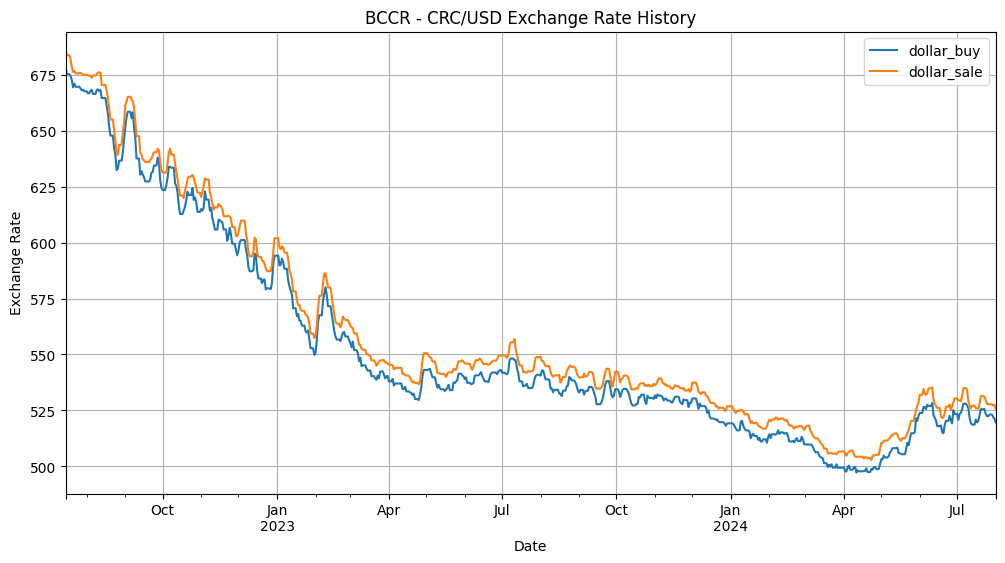

In [57]:
# Plotting
today = datetime.today().strftime('%Y-%m-%d')
# period = ['2022-01-01' , '2024-07-19']
period = ['2022-07-15' , today]
#
df[ (df.index >= period[0]) & (df.index <= period[1]) ].plot(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('BCCR - CRC/USD Exchange Rate History')
plt.grid(True)
plt.show()


### Backing up the dataframe to a local file

In [58]:
# Storing the processed data backup as different kinds of files,
# to see which type is more convenient in terms of space

pd.to_pickle(df, f'{DATASETS_BACKUP_PATH}/{CURRENT_DATASET_BASEFILENAME}.pkl')
df.to_csv(f'{DATASETS_BACKUP_PATH}/{CURRENT_DATASET_BASEFILENAME}.csv')
df.to_excel(f'{DATASETS_BACKUP_PATH}/{CURRENT_DATASET_BASEFILENAME}.xlsx')
df.to_parquet(f'{DATASETS_BACKUP_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet')

In [59]:
# Parquet file seems to be the smallest way to store backups
!date; ls -lhSr datasets/*

jue  1 ago 01:49:14 CST 2024
-rw-r--r-- 1 milos milos 189K jul 22 17:55 datasets/bccr_historial_cambio_dolar.parquet
-rw-rw-r-- 1 milos milos 2,8M ago  1 01:48 datasets/bccr_historial_cambio_dolar.html

datasets/temp:
total 0

datasets/backups:
total 6,9M
-rw-r--r-- 1 milos milos 189K ago  1 01:49 bccr_historial_cambio_dolar.parquet
-rw-r--r-- 1 milos milos 267K ago  1 01:49 bccr_historial_cambio_dolar.xlsx
-rw-r--r-- 1 milos milos 358K ago  1 01:49 bccr_historial_cambio_dolar.pkl
-rw-r--r-- 1 milos milos 360K ago  1 01:49 bccr_historial_cambio_dolar.csv
-rw-r--r-- 1 milos milos 2,9M jul 22 17:54 bccr_historial_cambio_dolar.html.20240722
-rw-rw-r-- 1 milos milos 2,9M ago  1 01:48 bccr_historial_cambio_dolar.html.20240801


In [60]:
#Types of files as seen by Linux OS
!file datasets/backups/*

datasets/backups/bccr_historial_cambio_dolar.csv:           ASCII text
datasets/backups/bccr_historial_cambio_dolar.html.20240722: HTML document, ASCII text, with CRLF line terminators
datasets/backups/bccr_historial_cambio_dolar.html.20240801: HTML document, ASCII text, with CRLF line terminators
datasets/backups/bccr_historial_cambio_dolar.parquet:       Apache Parquet
datasets/backups/bccr_historial_cambio_dolar.pkl:           XENIX 8086 relocatable or 80286 small model
datasets/backups/bccr_historial_cambio_dolar.xlsx:          Zip archive data, at least v2.0 to extract


In [61]:
# So, using parquet file to be the one placed at the datasets main path
df.to_parquet(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet')

In [62]:
os.listdir(DATASETS_PATH)

['bccr_historial_cambio_dolar.parquet',
 'backups',
 'bccr_historial_cambio_dolar.html',
 'temp']

In [63]:
magic.from_file(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet')

'Apache Parquet'

## Webscraping the latest data from the bank webpage, with BeautifulSoup

Only the last 30 days have records at the page.

In [64]:
# Scraping the most recent data from the bank webpage

# Configuration

host='gee.bccr.fi.cr'
urlpath='indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx'
# Sending some headers to try and hide the scraper default values
hdrs={'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36",
      'Host' : 'gee.bccr.fi.cr',
      'Accept-Language': 'en-US,en;q=0.9,es;q=0.8,es-CR;q=0.7,de;q=0.6'
      }
querystring = {'idioma': '1' , 'CodCuadro': ' 400'}
url_page = f'https://{host}/{urlpath}'

In [65]:
# Performing the actual request
page_request = requests.get(url_page, headers=hdrs , params= querystring)


In [66]:
# some interesting options that could be used
page_request.status_code, page_request.reason ,  page_request.ok , page_request.url , \
page_request.headers['Content-Length'], page_request.headers['Date'] , page_request.encoding

(200,
 'OK',
 True,
 'https://gee.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?idioma=1&CodCuadro=+400',
 '9259',
 'Thu, 01 Aug 2024 07:49:14 GMT',
 'utf-8')

In [67]:
# Here are all the headers in case we need more info
page_request.headers

{'Cache-Control': 'private', 'Content-Type': 'text/html; charset=utf-8', 'Content-Encoding': 'gzip', 'Expires': 'Thu, 01 Aug 2024 07:49:15 GMT', 'Vary': 'Accept-Encoding', 'Set-Cookie': 'ASP.NET_SessionId=aotcpemp4jxriitz3qyemyrw; path=/; secure; HttpOnly; SameSite=Lax, dtCookie=v_4_srv_4_sn_D439232AD858DBFD828AC623895254EB_perc_100000_ol_0_mul_1_app-3Aa1722fd1705f96bf_0; Path=/; Domain=.bccr.fi.cr, TS01e64794=01da735af047a2119e1f5545f63e684d684f6fc6a8bdb157b3bdcc5d5f59b3d64f14b212d4432aa23f6c9db080d8528714de2d973e9d63bae55b05402e933403f559aa6820; Path=/; Secure; HTTPOnly, TS0194aa71=01da735af0edb858b7d1365b20f1ac3c2a56c2ed70bdb157b3bdcc5d5f59b3d64f14b212d43538667a2f1fa48a8b5429e8e93d16c0935bf6dc3e8237e8abcf92beec46a99e; path=/; domain=.bccr.fi.cr; HTTPonly; Secure', 'Content-Security-Policy': "script-src 'unsafe-inline' 'unsafe-eval' https://www.google.com/recaptcha/api.js *.gstatic.com https://gee.bccr.fi.cr https://centralenlinea.bccr.fi.cr; object-src 'self'; frame-ancestors 'self'

In [68]:
# page_request.text

In [69]:
# Validating that request made to website page was responsive
# If yes, then generate the soup object.  If not, print an error

if page_request.status_code == 200:
    print('Success!',page_request.status_code)
    # page_soup = bs(page_request.text, 'html.parser')
    page_soup = bs(page_request.text, 'html5lib')  #project went better with this one
    # page_soup = bs(page_request.text, 'lxml')
elif page.status_code != 200:
    print('Not Found. Status code was: ', page_request.status_code)

Success! 200


The table with whe dollar exchange data is defined by

\<table border="0" cellpadding="0" cellspacing="0" id="theTable400" width="400">

In [70]:
# page_soup

In [71]:
# Extracting the main table
# As per the inspection, the distinctive id of the needed table is table id="theTable400"

dollar_exch_table = page_soup.find('table', attrs={'id': 'theTable400'})
# dollar_exch_table

In [72]:
# The main table is made up of 3 rows (tr):
# 1: table headers
# 2: the actual data
# 3: some notes from the bank, not needed for this project

In [73]:
# Extracting table headers

hrdrs_tags = dollar_exch_table.find_all('tr')[0]
hrdrs_tags

<tr>
            <td height="100%" width="200">
                <table border="0" cellpadding="0" cellspacing="0" height="100%" width="200">
                    <tbody><tr style="background-color:#0C365E">
                        <td class="frame400"> 
                        </td>
                    </tr>
                </tbody></table>
            </td>
            <td align="center" bgcolor="#0C365E" class="frame400" height="100%" id="leaves400" isleaf="true" parentidx="td_0" style="color:white" valign="center" width="100">
                TIPO CAMBIO COMPRA  
            </td>
            <td align="center" bgcolor="#0C365E" class="frame400" height="100%" id="leaves400" isleaf="true" parentidx="td_0" style="color:white" valign="center" width="100">
                TIPO DE CAMBIO VENTA  
            </td>
        </tr>

In [74]:
# This tr above has 3 td on the inside.  The first one should say "dates" , but instead it has an empty table...
# So we will ignore that one and get just the other two, and those have a distinctive  id="leaves400"

hrdrs_tags.find_all('td' , attrs={'id': 'leaves400'})

[<td align="center" bgcolor="#0C365E" class="frame400" height="100%" id="leaves400" isleaf="true" parentidx="td_0" style="color:white" valign="center" width="100">
                 TIPO CAMBIO COMPRA  
             </td>,
 <td align="center" bgcolor="#0C365E" class="frame400" height="100%" id="leaves400" isleaf="true" parentidx="td_0" style="color:white" valign="center" width="100">
                 TIPO DE CAMBIO VENTA  
             </td>]

In [75]:
hdrs_list = ['date'] #initiating the headers list with the missing data header
for item in hrdrs_tags.find_all('td' , attrs={'id': 'leaves400'}) :
  hdrs_row = item.text.strip()
  # print(hdrs_row)
  hdrs_list.append(hdrs_row)

hdrs_list

['date', 'TIPO CAMBIO COMPRA', 'TIPO DE CAMBIO VENTA']

In [76]:
# Extracting data

# Going back to the main table, notice that second tr contains all the rest of the data, in table tags.
# Data is stored in columns.  Upon inspection, and by checking the 5 indexes of the table below the tr[2],
# Is is found that index 0 contains the dates, 1 and 2 are identical and contain the dollar buy price, and
# 3 and 4 contain the dollar sale price.
# Indexes 0, 1 and 3 are chosen then

In [77]:
# dates
dollar_exch_table.find_all('tr')[2].find_all('table')[0].find_all('td')[-3:]

[<td bgcolor="#DFEDFF" class="celda400" style="color:Black">
                             30 Jul 2024
                         </td>,
 <td class="celda400">
                             31 Jul 2024
                         </td>,
 <td bgcolor="#DFEDFF" class="celda400" style="color:Black">
                             1 Ago 2024
                         </td>]

In [78]:
dates_list = []
for item in dollar_exch_table.find_all('tr')[2].find_all('table')[0].find_all('td',{'class':'celda400'}):
  dates_list.append(item.text.strip())
# count of items, and a tail sample of the dates list
len(dates_list) , dates_list[-3:]

(30, ['30 Jul 2024', '31 Jul 2024', '1 Ago 2024'])

In [79]:
# dollar buy price
dollar_exch_table.find_all('tr')[2].find_all('table')[1].find_all('td',{'class':'celda400'})[-3:]

[<td align="right" bgcolor="#DFEDFF" class="celda400" style="color:Black" valign="center" width="100">
                                         522,02
                                     </td>,
 <td align="right" class="celda400" valign="center" width="100">
                                         521,33
                                     </td>,
 <td align="right" bgcolor="#DFEDFF" class="celda400" style="color:Black" valign="center" width="100">
                                         519,64
                                     </td>]

In [80]:
dollar_buy_list = []
for item in dollar_exch_table.find_all('tr')[2].find_all('table')[1].find_all('td',{'class':'celda400'}):
#fixing the comma used as decimal point from here  , and converting str to float16
  dollar_buy_list.append(  np.float16 ( item.text.strip().replace(',','.') )  )

# count of items, and a tail sample of dollar_buy_list
len(dollar_buy_list) , dollar_buy_list[-3:]

(30, [np.float16(522.0), np.float16(521.5), np.float16(519.5)])

In [81]:
# dollar sale price
dollar_exch_table.find_all('tr')[2].find_all('table')[3].find_all('td',{'class':'celda400'})[-3:]

[<td align="right" bgcolor="#DFEDFF" class="celda400" style="color:Black" valign="center" width="100">
                                         527,18
                                     </td>,
 <td align="right" class="celda400" valign="center" width="100">
                                         527,61
                                     </td>,
 <td align="right" bgcolor="#DFEDFF" class="celda400" style="color:Black" valign="center" width="100">
                                         525,72
                                     </td>]

In [82]:
dollar_sale_list = []
for item in dollar_exch_table.find_all('tr')[2].find_all('table')[3].find_all('td',{'class':'celda400'}):
#fixing the comma used as decimal point from here  , and converting str to float16
  dollar_sale_list.append(  np.float16 ( item.text.strip().replace(',','.') )  )
# count of items, and a tail sample of dollar_sale_list
len(dollar_sale_list) , dollar_sale_list[-3:]

(30, [np.float16(527.0), np.float16(527.5), np.float16(525.5)])

### Building the dataframe using the extracted data

In [83]:
# First lets unify the date and exchange lists into a single table
# Above it was ensured that the lists all have the same lenght, in this case, 30.

list(zip(dates_list , dollar_buy_list , dollar_sale_list))[:3]

[('3 Jul 2024', np.float16(523.5), np.float16(529.5)),
 ('4 Jul 2024', np.float16(524.0), np.float16(529.0)),
 ('5 Jul 2024', np.float16(525.5), np.float16(531.5))]

In [84]:
# Looks good, saving it into an array
dollar_exchange_array = list(zip(dates_list , dollar_buy_list , dollar_sale_list))

In [85]:
# First test to see how df is seen
pd.DataFrame(dollar_exchange_array, columns=hdrs_list).tail(3)

,date,TIPO CAMBIO COMPRA,TIPO DE CAMBIO VENTA
27,30 Jul 2024,522.00,527.00
28,31 Jul 2024,521.50,527.50
29,1 Ago 2024,519.50,525.50


In [86]:
# Similar to our previous taks of this project, we should import the df properly, by:

# -setting the header as the resulting line with index 0
# -setting the index as the first column
# -recognizing the original decimal char as the comma, so dataframe is shown as usual with it as a dot #fixed before, when created the dollar lists
# -set floating numbers (fixed before, when created the dollar lists) with 2 decimals
# -name the columns properly
cols=['date', 'dollar_buy','dollar_sale']
pd.options.display.float_format = "{:,.2f}".format

df_dolExch_lst30d = pd.DataFrame(dollar_exchange_array, columns=cols)
# df_dolExch_lst30d.replace({',{1}' : '.'} , regex=True, inplace=True)   #fixed before, when created the dollar lists
df_dolExch_lst30d.infer_objects().dtypes
df_dolExch_lst30d.set_index('date', inplace=True)

df_dolExch_lst30d.tail(3)


,dollar_buy,dollar_sale
date,,
30 Jul 2024,522.00,527.00
31 Jul 2024,521.50,527.50
1 Ago 2024,519.50,525.50


In [87]:
# But, just like in the file extracion before, the dates do have month names in spanish
# Lets rename them to english so pandas does not fail when changing the date index format to datetime

for spa, eng in months_spa_to_eng.items():
    df_dolExch_lst30d.index = df_dolExch_lst30d.index.str.replace(spa, eng)

df_dolExch_lst30d.tail(3)

,dollar_buy,dollar_sale
date,,
30 Jul 2024,522.00,527.00
31 Jul 2024,521.50,527.50
1 Aug 2024,519.50,525.50


In [88]:
df_dolExch_lst30d.index.dtype.name

'object'

In [89]:
# Now we can finally apply the datetime format to the index
df_dolExch_lst30d.index = pd.to_datetime(df_dolExch_lst30d.index, format='mixed', dayfirst=True)

df_dolExch_lst30d.tail(3)

,dollar_buy,dollar_sale
date,,
2024-07-30,522.00,527.00
2024-07-31,521.50,527.50
2024-08-01,519.50,525.50


In [90]:
df_dolExch_lst30d.index.dtype.name

'datetime64[ns]'

In [91]:
# If the format of the dollar colums was not corrected before at the dollar list code (but it did)
# we could use the following lines by uncommenting them

# df_dolExch_lst30d.dollar_buy =  df_dolExch_lst30d.dollar_buy.astype('float16')
# df_dolExch_lst30d.dollar_sale =  df_dolExch_lst30d.dollar_sale.astype('float16')

In [92]:
df_dolExch_lst30d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2024-07-03 to 2024-08-01
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dollar_buy   30 non-null     float16
 1   dollar_sale  30 non-null     float16
dtypes: float16(2)
memory usage: 360.0 bytes




---


### Addition of recent dollar exchange rate values to the accumulated dataset/file

The idea is to mimic the following scenario:   

We already have a csv(or parquet) file with the full historical values of the dollar exchange rate, which we use to plot that exchange rate daily.  

The full data for that file is not downloaded daily. It was simply downloaded in the past ( ideally no more than 30 days prior to current date)  

In [93]:
list(os.walk(DATASETS_PATH))

[('./datasets',
  ['backups', 'temp'],
  ['bccr_historial_cambio_dolar.parquet', 'bccr_historial_cambio_dolar.html']),
 ('./datasets/backups',
  [],
  ['bccr_historial_cambio_dolar.parquet',
   'bccr_historial_cambio_dolar.csv',
   'bccr_historial_cambio_dolar.html.20240722',
   'bccr_historial_cambio_dolar.html.20240801',
   'bccr_historial_cambio_dolar.pkl',
   'bccr_historial_cambio_dolar.xlsx']),
 ('./datasets/temp', [], [])]

In [94]:
datetime.fromtimestamp  (os.path.getctime(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet')).strftime('%Y-%m-%d %H:%M')

'2024-08-01 01:49'

In [95]:
current_dataset_file_creationTstamp = datetime.fromtimestamp (os.path.getctime(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet')).strftime('%Y-%m-%d %H:%M')

In [96]:
print(f'Current dataset file in use: {DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet \ncreation time: {current_dataset_file_creationTstamp}')

Current dataset file in use: ./datasets/bccr_historial_cambio_dolar.parquet 
creation time: 2024-08-01 01:49




For speed, and to save on IT resources, we just scrape the daily updated records from the bank's website, that only have the most recent 30 days, so we then add that most recent data to the full historical values file/dataset according to the missing data up to today's date.

In general, every day the missing data would be today's data.




In [97]:
# Simulating the load of the last updated exchange data file, in to a new dataframe

df_dolExch_lst30d_yesterday_simulation = pd.read_parquet(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet')
df_dolExch_lst30d_yesterday_simulation.tail(3)

,dollar_buy,dollar_sale
date,,
2024-07-30,522.02,527.18
2024-07-31,521.33,527.61
2024-08-01,519.64,525.72


In [98]:
# Deleting the last record of that last updated exchange data file (today's record)
# to simulate as if the data is from yesterday, to then add today's record later,
# from recent scraped data

df_dolExch_lst30d_yesterday_simulation.drop(df_dolExch_lst30d_yesterday_simulation.index[-1], inplace=True)
df_dolExch_lst30d_yesterday_simulation.tail(3)

,dollar_buy,dollar_sale
date,,
2024-07-29,523.18,527.73
2024-07-30,522.02,527.18
2024-07-31,521.33,527.61


In [99]:
# Checking today's scraped data again, its last record should be
# today's record according the bank's website

df_dolExch_lst30d.tail(1)

,dollar_buy,dollar_sale
date,,
2024-08-01,519.50,525.50


In [100]:
# Adding today's record to the yesterday's simulated df
df_dolExch_updated = pd.concat([df_dolExch_lst30d_yesterday_simulation, df_dolExch_lst30d.tail(1)])

# The updated df
df_dolExch_updated.tail(3)


,dollar_buy,dollar_sale
date,,
2024-07-30,522.02,527.18
2024-07-31,521.33,527.61
2024-08-01,519.50,525.50


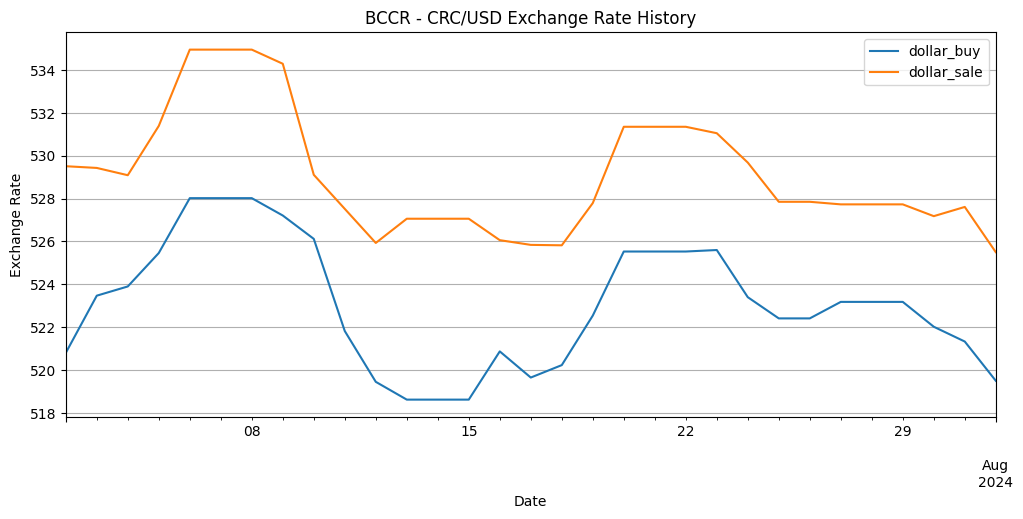

In [101]:
# Plotting.   Today's dollar exchange rate is shown on the plot of the updated df

today = datetime.today().strftime('%Y-%m-%d')
period = ['2024-07-02' , today]


df_dolExch_updated[ (df_dolExch_updated.index >= period[0]) & (df_dolExch_updated.index <= period[1]) ].plot(figsize=(12, 5))
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('BCCR - CRC/USD Exchange Rate History')
plt.grid(True)
plt.show()

In [102]:
# Now lets update the exchange data file, using the updated dataframe

df_dolExch_updated.to_parquet(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet')

In [103]:
current_dataset_file_creationTstamp = datetime.fromtimestamp (os.path.getctime(f'{DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet')).strftime('%Y-%m-%d %H:%M')

print(f'Current dataset file has been updated: {DATASETS_PATH}/{CURRENT_DATASET_BASEFILENAME}.parquet \ncreation time: {current_dataset_file_creationTstamp} \nCurrent date-time is:', datetime.today().strftime('%Y-%m-%d %H:%M'))

Current dataset file has been updated: ./datasets/bccr_historial_cambio_dolar.parquet 
creation time: 2024-08-01 01:49 
Current date-time is: 2024-08-01 01:49


In [104]:
os.listdir(DATASETS_PATH)

['bccr_historial_cambio_dolar.parquet',
 'backups',
 'bccr_historial_cambio_dolar.html',
 'temp']

In [105]:
!date; ls -ls datasets

jue  1 ago 01:49:21 CST 2024
total 3020
   4 drwxr-xr-x 2 milos milos    4096 ago  1 01:48 backups
2820 -rw-rw-r-- 1 milos milos 2885940 ago  1 01:48 bccr_historial_cambio_dolar.html
 192 -rw-r--r-- 1 milos milos  192959 ago  1 01:49 bccr_historial_cambio_dolar.parquet
   4 drwx------ 2 milos milos    4096 ago  1 01:48 temp




---


# Extra Experiment:  saving as html and then loading table into pandas

Because of the onconventional way the bank constructs the htlm tables, by column , I experimented by saving the html file and then apply a pandas.read_html from it, to see what happened.

It actually load 13 different tables, with mixed results of the needed rows and columns.

By inspecting them one could also extract the information.    

Some work is needed, but it is possible, here is an example below

In [106]:
with open('page.html', 'w') as file:
    file.write(page_request.text)

In [107]:
!ls -lh page.html ;head -4 page.html

-rw-rw-r-- 1 milos milos 73K ago  1 01:49 page.html
<HTML>
<HEAD><title>Tipo cambio de compra y de venta del dólar de los Estados Unidos de América</title>
<script type="text/javascript">var _gaq = _gaq || [];_gaq.push(['_setAccount', 'UA-25040215-3']);_gaq.push(['_trackPageview']);(function() {var ga = document.createElement('script'); ga.type = 'text/javascript'; ga.async = true;ga.src = ('https:' == document.location.protocol ? 'https://ssl' : 'http://www') + '.google-analytics.com/ga.js';var s = document.getElementsByTagName('script')[0]; s.parentNode.insertBefore(ga, s);})();</script>
<script language="javascript">


In [108]:
dol_buy = pd.read_html('page.html')[3][0][0].split('  ')

In [109]:
dol_buy

['523,47',
 '523,90',
 '525,46',
 '528,02',
 '528,02',
 '528,02',
 '527,21',
 '526,12',
 '521,82',
 '519,45',
 '518,62',
 '518,62',
 '518,62',
 '520,87',
 '519,65',
 '520,23',
 '522,54',
 '525,53',
 '525,53',
 '525,53',
 '525,60',
 '523,40',
 '522,41',
 '522,41',
 '523,18',
 '523,18',
 '523,18',
 '522,02',
 '521,33',
 '519,64']